# **Settings**

In [119]:
try:
  %tensorflow_version 2.x
  %load_ext tensorboard
except:
    pass

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [120]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [121]:
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import os
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [122]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# **Data Setup**

In [123]:
from keras.datasets import cifar10

In [124]:
(x_train, y_train_), (x_test, y_test_) = cifar10.load_data()

In [125]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [126]:
from keras.utils import to_categorical
y_train = to_categorical(y_train_)
y_test = to_categorical(y_test_)

# **CallBack**

In [127]:
class EarlyStoppingCallBack(keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(EarlyStoppingCallBack, self).__init__()
    self.prev_accuracy = -np.Inf
    self.patience = patience

  def on_train_begin(self, logs=None):
    self.best = np.Inf
    self.wait = 0   # counts the number of iterations that we have waited to see improvement
    self.stopped_epoch = 0

  def on_epoch_end(self, epoch, logs=None):
    current_loss = logs.get("val_loss")   # this metric should be in metrics while compiling,(Note that this is the accuracy of epoch number you gave as input)
    if np.less(current_loss, self.best):
      self.best = current_loss
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait +=1
      print("wait mode, stop: %d\n" % self.wait)
      if self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

# Check if that we stopped program by callback or not
  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print("epoch: %d early stopping" %self.stopped_epoch)

# **Model Definition**

In [128]:
from keras.models import Sequential


In [129]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [130]:
# define model by using regularizer

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01), input_shape=(32, 32, 3)))

model.add(MaxPool2D())

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [139]:
# define model using dropout

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', input_shape=(32, 32, 3)))
model.add(MaxPool2D())
model.add(keras.layers.Dropout(rate=0.1))

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(MaxPool2D())
model.add(keras.layers.Dropout(rate=0.1))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [140]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [132]:
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                40970     
Total params: 60,362
Trainable params: 60,362
Non-trainable params: 0
_________________________________________________

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [32]:
!rm -rf "/content/drive/MyDrive/ANN_HomeWorks/logs"

In [33]:
import os
os.chdir("/content/drive/MyDrive/ANN_HomeWorks")
os.mkdir("./logs")

In [141]:
# Fit with Callbacks (tensorboard, es)
tb_callback = keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)
es_callback = EarlyStoppingCallBack(patience=3)
history = model.fit(x_train, y_train, batch_size=50, epochs=15, validation_split=0.18, callbacks=[es_callback, tb_callback])

Epoch 1/15
820/820 [==============================] - 67s 82ms/step - loss: 1.5248 - accuracy: 0.4659 - val_loss: 1.2986 - val_accuracy: 0.5454
Epoch 2/15
820/820 [==============================] - 67s 82ms/step - loss: 1.2047 - accuracy: 0.5846 - val_loss: 1.1249 - val_accuracy: 0.6171
Epoch 3/15
820/820 [==============================] - 67s 82ms/step - loss: 1.0937 - accuracy: 0.6233 - val_loss: 1.1032 - val_accuracy: 0.6178
Epoch 4/15
820/820 [==============================] - 67s 82ms/step - loss: 1.0281 - accuracy: 0.6478 - val_loss: 1.0707 - val_accuracy: 0.6367
Epoch 5/15
820/820 [==============================] - 67s 82ms/step - loss: 0.9845 - accuracy: 0.6604 - val_loss: 1.0291 - val_accuracy: 0.6546
Epoch 6/15
820/820 [==============================] - 67s 82ms/step - loss: 0.9502 - accuracy: 0.6718 - val_loss: 1.0216 - val_accuracy: 0.6584
Epoch 7/15
820/820 [==============================] - 67s 82ms/step - loss: 0.9232 - accuracy: 0.6843 - val_loss: 1.0063 - val_accuracy:

In [ ]:
%tensorboard --logdir logs

In [142]:
# evaluating
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 1)

313/313 [==============================] - 5s 15ms/step - loss: 1.0128 - accuracy: 0.6549


In [143]:
# Predicting labels
from sklearn.metrics import confusion_matrix
predicted_values = model.predict(x_test)
predicted_classes = np.argmax(predicted_values, axis=1)
true_classes = np.argmax(y_test, axis=1)
cof_mat = confusion_matrix(true_classes, predicted_classes)


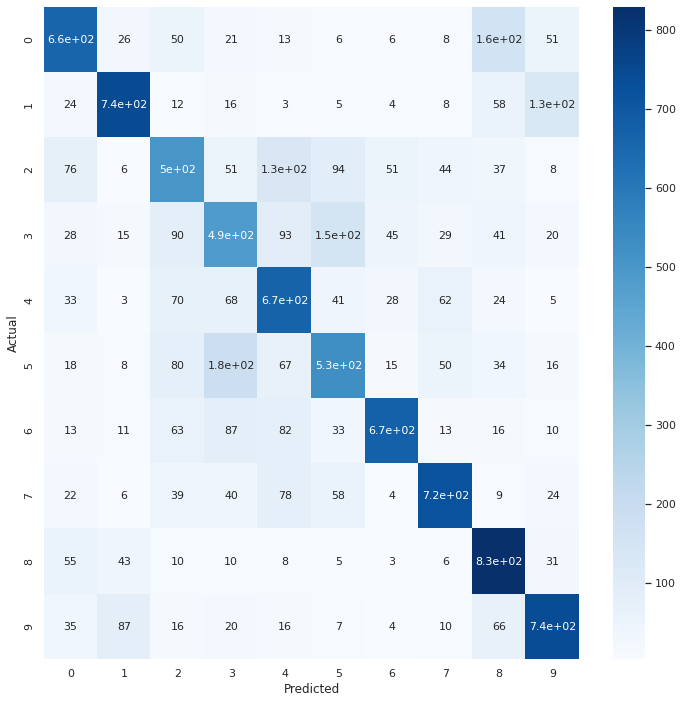

In [144]:

df_cm = pd.DataFrame(cof_mat, columns=np.unique(true_classes), index = np.unique(true_classes))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (12,12))
sn.set(font_scale=1.0)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 11})
